In [228]:
### Importing necessary libraries
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [128]:
train_dir=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\dataset\train'
test_dir=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\dataset\test'

for d in [train_dir, test_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)

train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])

print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  test_df length: ', len(test_df))

train_df lenght:  63265   test_df length:  7030   test_df length:  7030


In [129]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

The number of classes in the dataset is:  21
            CLASS               IMAGE COUNT 
         _Apple_scab               1814     
       _Bacterial_spot             4908     
          _Black_rot               3487     
      _Cedar_apple_rust            1584     
_Cercospora_leaf_spot Gray_leaf_spot     1478     
        _Common_rust_              1716     
        _Early_blight              3473     
    _Esca_(Black_Measles)          1728     
_Haunglongbing_(Citrus_greening)     1809     
         _Late_blight              3411     
          _Leaf_Mold               1694     
_Leaf_blight_(Isariopsis_Leaf_Spot)     1550     
         _Leaf_scorch              1597     
    _Northern_Leaf_Blight          1717     
       _Powdery_mildew             3077     
     _Septoria_leaf_spot           1571     
_Spider_mites Two-spotted_spider_mite     1567     
         _Target_Spot              1644     
_Tomato_Yellow_Leaf_Curl_Virus     1765     
     _Tomato_mosaic_virus          

### Create the train_gen, test_gen

In [4]:
# get the classes with the minimum and maximum number of train images
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

_healthy  has the most images=  20064   _Cercospora_leaf_spot Gray_leaf_spot  has the least images=  1478


In [5]:
# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 100 random samples of train_df
train_df_sample = train_df.sample(n= 100, random_state= 123, axis= 0)

for i in range(len(train_df_sample)):
    
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    
    ht += shape[0]
    wt += shape[1]

print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

average height=  256  average width=  256 aspect ratio=  1.0


In [6]:
train_gen = ImageDataGenerator(rescale=None, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = train_gen.flow_from_directory(train_dir, target_size=(128,128), batch_size=32, class_mode='categorical')

test_set=test_gen.flow_from_directory(test_dir, target_size=(128,128), batch_size=32, class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [156]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen) # get a sample batch from the generator 
    
    plt.figure(figsize=(20, 20))
    
    length=len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        
        index=np.argmax(labels[i])
        class_name=classes[index]
        
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
        
    plt.show()

In [2]:
# print("Images for Training......................")
# show_image_samples(training_set )

In [1]:
# print("Images for Testing.......................")
# show_image_samples(test_set)

### Convolutional Neural Network

    Basic CNN layers

In [146]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.3))
model.add(Dense(38, activation='softmax'))

In [147]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model training

In [148]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 63, 63, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                      

In [20]:
### Fitting data into our model

fitted_model = model.fit(training_set, steps_per_epoch=375, epochs=10, validation_data = test_set, validation_steps = 125)

Epoch 1/10
375/375 [==============================] - 297s 783ms/step - loss: 2.5377 - accuracy: 0.2921 - val_loss: 2.3504 - val_accuracy: 0.3002
Epoch 2/10
375/375 [==============================] - 257s 686ms/step - loss: 1.6140 - accuracy: 0.5089 - val_loss: 1.7953 - val_accuracy: 0.4665
Epoch 3/10
375/375 [==============================] - 230s 613ms/step - loss: 1.2747 - accuracy: 0.6070 - val_loss: 1.3072 - val_accuracy: 0.5930
Epoch 4/10
375/375 [==============================] - 209s 557ms/step - loss: 1.0645 - accuracy: 0.6695 - val_loss: 1.0230 - val_accuracy: 0.6768
Epoch 5/10
375/375 [==============================] - 198s 527ms/step - loss: 0.9318 - accuracy: 0.7082 - val_loss: 0.6815 - val_accuracy: 0.7788
Epoch 6/10
375/375 [==============================] - 211s 563ms/step - loss: 0.8136 - accuracy: 0.7438 - val_loss: 1.0244 - val_accuracy: 0.6760
Epoch 7/10
375/375 [==============================] - 303s 809ms/step - loss: 0.7451 - accuracy: 0.7605 - val_loss: 0.5877 -

In [79]:
fitted_model

### Convert the model into Pickle file

In [67]:
# pickle.dump(model, open('Leaf_disease_detection.pkl', 'wb'))

### Load the pickle file

In [72]:
ldd_model = pickle.load(open('Leaf_disease_detection.pkl', 'rb'))

In [73]:
ldd_model

In [74]:
ldd_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                      

In [19]:
labels = (training_set.class_indices)
labels2 = (test_set.class_indices)

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc)+ start_epoch
    
    Epochs = []
    
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    
    index_loss = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    #plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label = 'best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes = plt.subplots(nrows=1, ncols= 3, figsize=(10,6))
    
    axes[0].plot(Epochs, tloss, 'r', label = 'Training loss')
    axes[0].plot(Epochs, vloss,'b',label = 'Validation loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s= 150, c = 'black', label = sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc,'r',label= 'Training Accuracy')
    axes[1].plot(Epochs, vacc,'b',label= 'Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s= 150, c = 'black', label = vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout    
    plt.show()


In [ ]:
tr_plot(fitted_model, 0)

In [200]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=125)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 [==============================] - 58s 458ms/step - loss: 14.3181 - accuracy: 0.0295
Test loss: 14.31811809539795
Test accuracy: 0.029500000178813934


In [229]:
# Adjust the learning rate
initial_learning_rate = 1e-4
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [231]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [232]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

In [234]:
fitted_model1 = model.fit(training_set, steps_per_epoch=len(training_set), epochs=5, validation_data=test_set, validation_steps=len(test_set), callbacks=callbacks)

Epoch 1/5
2197/2197 [==============================] - 1497s 681ms/step - loss: 2.5806 - accuracy: 0.2925 - val_loss: 1.9976 - val_accuracy: 0.4231
Epoch 2/5
2197/2197 [==============================] - 753s 343ms/step - loss: 1.5652 - accuracy: 0.5319 - val_loss: 1.4916 - val_accuracy: 0.5727
Epoch 3/5
2197/2197 [==============================] - 3128s 1s/step - loss: 1.1562 - accuracy: 0.6481 - val_loss: 1.2771 - val_accuracy: 0.6333
Epoch 4/5
2197/2197 [==============================] - 767s 349ms/step - loss: 0.9308 - accuracy: 0.7112 - val_loss: 1.1413 - val_accuracy: 0.6854
Epoch 5/5
2197/2197 [==============================] - 821s 374ms/step - loss: 0.7878 - accuracy: 0.7537 - val_loss: 1.2587 - val_accuracy: 0.6769


In [ ]:
tr_plot(fitted_model1, 0)

In [236]:
# pickle.dump(model, open('Leaf_disease_detection_1.pkl', 'wb'))

In [238]:
ldd_model1 = pickle.load(open('Leaf_disease_detection_1.pkl', 'rb'))

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

543/550 [============================>.] - ETA: 7s - loss: 3.8080 - accuracy: 0.0334

In [168]:
label = os.listdir(train_dir1) # your directory path

In [169]:
len(label)

38

## Predicting Output

In [170]:
#path=input("Enter your image path-: ")
def testing(path, ldd_model):
    
    test_image = image.load_img(path, target_size=(128,128))
    
    test_image = image.img_to_array(test_image)
    
    test_image = np.expand_dims(test_image, axis=0)
    
    result = ldd_model.predict(test_image)

    #print(f"Result is --> {result}")
    fresult = np.max(result)
    label2 = label[result.argmax()]
    
    print(f"your leaf disease is --> {label2}")

In [171]:
img_path=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\images_for_test\CornCommonRust1.JPG'

testing(img_path, ldd_model)

1/1 [==============================] - 0s 30ms/step
your leaf disease is --> Corn_(maize)___Common_rust_


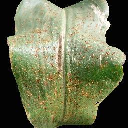

In [172]:
## Sample Image

image.load_img(path, target_size=(128, 128))